In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



In [23]:
# Load Dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

# Display the first few rows of the dataframe
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


# Data Exploring

In [24]:
# Check for missing values in the DataFrame
missing_values = df_train.isnull().sum()

# Calculate the percentage of missing values
missing_percentage = (missing_values / len(df_train)) * 100

# Display the columns with missing values and their percentage
print(missing_percentage[missing_percentage > 0])

fuel_type       2.696080
accident        1.300568
clean_title    11.360876
dtype: float64


In [25]:
# Get the unique values of the fuel_type column
unique_fuel_types = df_train['fuel_type'].unique()

# Display the unique values
print(unique_fuel_types)

['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']


Highest Price: 2954083
Lowest Price: 2000
Average Price: 43878.01617753921


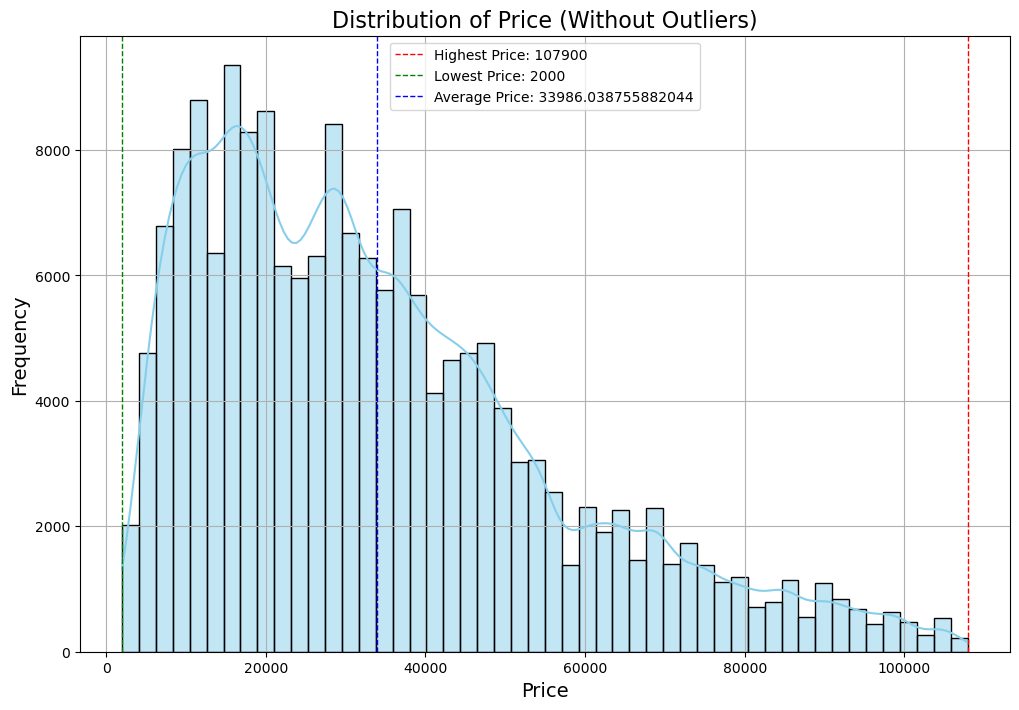

In [36]:
# Calculate highest, lowest, and average price
highest_price = df_train['price'].max()
lowest_price = df_train['price'].min()
average_price = df_train['price'].mean()

print(f"Highest Price: {highest_price}")
print(f"Lowest Price: {lowest_price}")
print(f"Average Price: {average_price}")

# Filter outliers to see them on the graph better
upper_bound = df_train['price'].quantile(0.95)
filtered_df = df_train[(df_train['price'] <= upper_bound)]

# Plot
plt.figure(figsize=(12, 8))
sns.histplot(filtered_df['price'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Price (Without Outliers)', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(filtered_df['price'].max(), color='red', linestyle='dashed', linewidth=1, label=f'Highest Price: {filtered_df["price"].max()}')
plt.axvline(filtered_df['price'].min(), color='green', linestyle='dashed', linewidth=1, label=f'Lowest Price: {filtered_df["price"].min()}')
plt.axvline(filtered_df['price'].mean(), color='blue', linestyle='dashed', linewidth=1, label=f'Average Price: {filtered_df["price"].mean()}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# going to get rid of the outliers from the train set
df_train = df_train[(df_train['price'] <= 250000)]
